# lime & Shapley Value

In [81]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import metrics

import lime
import lime.lime_tabular

import shap

import matplotlib.pyplot as plt

In [82]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [83]:
train.head()

LIMIT_BAL  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0   340000.0     8571.0    21012.0    10607.0    47258.0    35675.0   
1   100000.0    32196.0    31379.0    33862.0    35007.0    34147.0   
2   130000.0      500.0     2000.0     1354.0        0.0        0.0   
3   150000.0        0.0        0.0        0.0        0.0        0.0   
4   240000.0   177221.0   169897.0   166064.0        0.0        0.0   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  ...  Sex_Education_Marriage_232  \
0    20691.0   21041.0   10607.0   47258.0  ...                           0   
1    35437.0       0.0    3000.0    2000.0  ...                           0   
2     2699.0    2000.0    1354.0       0.0  ...                           0   
3        0.0       0.0       0.0       0.0  ...                           0   
4        0.0    7053.0    6520.0       0.0  ...                           0   

   Sex_Education_Marriage_233  Sex_Education_Marriage_241  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   Sex_Education_Marriage_242  Sex_Education_Marriage_243  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   Age_category_29 - 34  Age_category_35 - 41  Age_category_<=28  \
0                     1                     0                  0   
1                     0                     1                  0   
2                     0                     0                  1   
3                     0                     0                  0   
4                     0                     0                  0   

   Age_category_>41  default.payment.next.month  
0                 0                           0  
1                 0                           1  
2                 0                           1  
3                 1                           0  
4                 1                           1  

[5 rows x 147 columns]

In [84]:
# Create X_train,Y_train,X_test
X_train = train.drop(['default.payment.next.month'], axis=1)
y_train = train['default.payment.next.month']

X_test  = test.drop(['default.payment.next.month'], axis=1)
y_test  = test['default.payment.next.month']

In [85]:
lgbm = LGBMClassifier(learning_rate= 0.1, n_estimators= 100, num_leaves= 25)
lgbm_result = lgbm.fit(X_test, y_test)
light_gbm_preds = lgbm.predict(X_test)
print('The accuracy of the lightGBM model is :\t',metrics.accuracy_score(light_gbm_preds,y_test))

The accuracy of the lightGBM model is :	 0.8886666666666667


In [86]:
def get_percentile_dict(yhat, id_, frame):
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

In [87]:
X=X_test.copy(deep=True)
X['ID']=X.index.values
features=X.drop(columns = ['ID']).columns.values.tolist()

# merge GBM predictions onto test data
yhat_test = pd.concat([X.reset_index(drop=True), pd.DataFrame(lgbm.predict_proba(X[features]))],
                      axis=1)
yhat_test

LIMIT_BAL  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0      170000.0    53145.0    52131.0    45987.0    35377.0    29141.0   
1       60000.0    13123.0    14403.0    16150.0    17870.0    19571.0   
2      240000.0   160161.0   159484.0   162231.0   163255.0   165436.0   
3       50000.0     5814.0      -73.0    11427.0      191.0     7391.0   
4      200000.0     1554.0     1645.0     1408.0     1800.0      819.0   
...         ...        ...        ...        ...        ...        ...   
5995   150000.0        0.0        0.0        0.0      116.0        0.0   
5996   200000.0        0.0        0.0        0.0        0.0     1830.0   
5997   260000.0     1891.0     2438.0     2280.0      746.0     1989.0   
5998   170000.0    26151.0    24019.0    26013.0    24471.0    23496.0   
5999   240000.0     3328.0   164327.0    10690.0     4772.0     1294.0   

      BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  ...  \
0       21955.0    2005.0    2000.0    1514.0  ...   
1       21235.0    1500.0    2000.0    2000.0  ...   
2      168178.0    7405.0    8005.0    6005.0  ...   
3        6554.0       0.0   11500.0     191.0  ...   
4         886.0    1345.0    1108.0     669.0  ...   
...         ...       ...       ...       ...  ...   
5995     1500.0       0.0       0.0     116.0  ...   
5996        0.0       0.0       0.0       0.0  ...   
5997     1668.0    2637.0    2280.0     746.0  ...   
5998    25333.0    3000.0    5000.0    2000.0  ...   
5999     2147.0  164820.0   11728.0    7738.0  ...   

      Sex_Education_Marriage_241  Sex_Education_Marriage_242  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           0   
...                          ...                         ...   
5995                           0                           0   
5996                           0                           0   
5997                           0                           0   
5998                           0                           0   
5999                           0                           0   

      Sex_Education_Marriage_243  Age_category_29 - 34  Age_category_35 - 41  \
0                              0                     1                     0   
1                              0                     0                     0   
2                              0                     0                     1   
3                              0                     0                     0   
4                              0                     0                     0   
...                          ...                   ...                   ...   
5995                           0                     1                     0   
5996                           0                     0                     0   
5997                           0                     0                     1   
5998                           0                     0                     0   
5999                           0                     0                     0   

      Age_category_<=28  Age_category_>41    ID         0         1  
0                     0                 0     0  0.957238  0.042762  
1                     1                 0     1  0.854439  0.145561  
2                     0                 0     2  0.635775  0.364225  
3                     1                 0     3  0.917023  0.082977  
4                     0                 1     4  0.866077  0.133923  
...                 ...               ...   ...       ...       ...  
5995                  0                 0  5995  0.884608  0.115392  
5996                  0                 1  5996  0.799610  0.200390  
5997                  0                 0  5997  0.942135  0.057865  
5998                  1               

In [88]:
X=X_test.copy(deep=True)
X['ID']=X.index.values
features=X.drop(columns = ['ID']).columns.values.tolist()

# merge GBM predictions onto test data
yhat_test = pd.concat([X.reset_index(drop=True), pd.DataFrame(lgbm.predict_proba(X[features]))],
                      axis=1)
yhat_test = yhat_test.rename(columns={1:'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict

{0: 5916,
 99: 787,
 10: 1301,
 20: 983,
 30: 3700,
 40: 1154,
 50: 4233,
 60: 2093,
 70: 5116,
 80: 24,
 90: 2715}

# lime

In [89]:
predict_fn_lgbm = lambda x: lgbm.predict_proba(x).astype(float)
X = X_train.values
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X,feature_names = X_train.columns,
                                                   class_names=['Will Not Default','Will Default'],kernel_width=5)

### instance 1

In [90]:
choosen_instance = X_test.iloc[[787]].values[0]
exp = explainer_lime.explain_instance(choosen_instance, predict_fn_lgbm,num_features=10)
exp.show_in_notebook(show_all=False)


### instance 2

In [91]:
choosen_instance = X_test.iloc[[5916]].values[0]
exp = explainer_lime.explain_instance(choosen_instance, predict_fn_lgbm,num_features=10)
exp.show_in_notebook(show_all=False)

### instance 3

In [92]:
choosen_instance = X_test.iloc[[4683]].values[0]
exp = explainer_lime.explain_instance(choosen_instance, predict_fn_lgbm,num_features=10)
exp.show_in_notebook(show_all=False)

# shapley

In [93]:
explainer = shap.TreeExplainer(lgbm_result,X_train)

shap_values = explainer.shap_values(X_test)

 96%|=================== | 5762/6000 [00:15<00:00]       

In [94]:
# visualize the first prediction's explanation (in log-odds scale)
print('Model prediction:', lgbm_result.predict_proba(X_test[787:788]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[787], X_test.iloc[787])


Model prediction: [[0.03811363 0.96188637]]


In [95]:
import math
x = 3.23
sigmoid = 1/(1+math.exp(-x))
sigmoid

0.9619477529290079

In [96]:
# visualize the first prediction's explanation (in log-odds scale)
print('Model prediction:', lgbm_result.predict_proba(X_test[5916:5917]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5916], X_test.iloc[5916])

Model prediction: [[0.99840317 0.00159683]]


In [97]:
# visualize the first prediction's explanation (in log-odds scale)
print('Model prediction:', lgbm_result.predict_proba(X_test[4683:4684]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4683], X_test.iloc[4683])

Model prediction: [[0.87534451 0.12465549]]


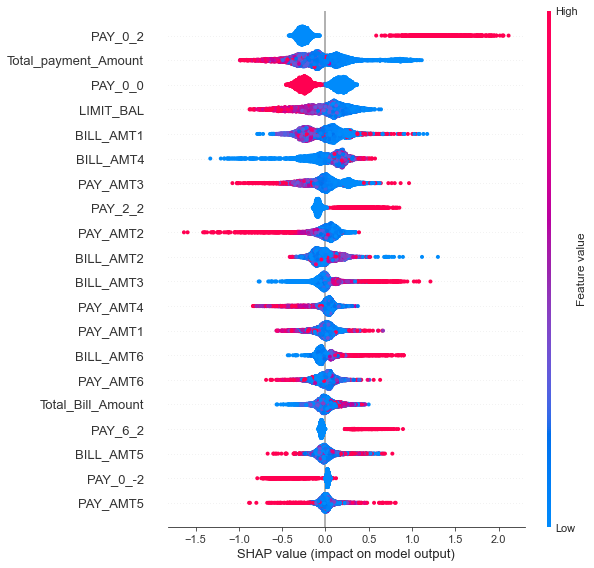

<Figure size 432x288 with 0 Axes>

In [98]:
shap.summary_plot(shap_values, X_test)
plt.savefig("p1.png",dpi=150, bbox_inches='tight')

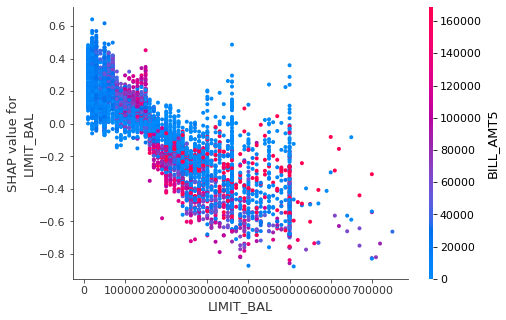

In [25]:
shap.dependence_plot('LIMIT_BAL', shap_values, X_test, interaction_index="BILL_AMT5")

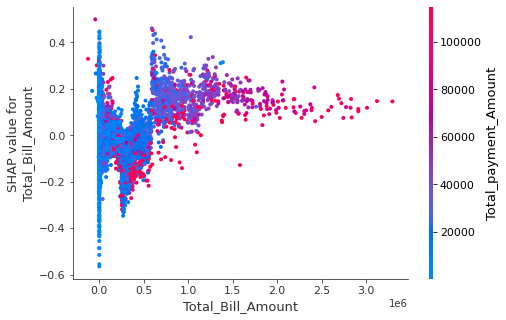

In [27]:
shap.dependence_plot('Total_Bill_Amount', shap_values, X_test, interaction_index="Total_payment_Amount")

In [28]:
shap.force_plot(explainer.expected_value, shap_values[::2000], X_test[::2000])

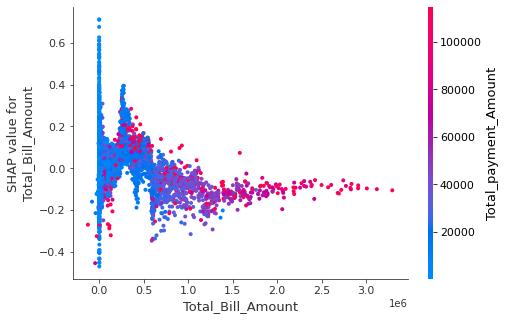

In [50]:
shap.dependence_plot('Total_Bill_Amount', shap_values[0], X_test, interaction_index="Total_payment_Amount")

# Reason code

In [71]:
def reason_codes(decile):
    '''
    decile = 0,10,20 ,30,40,50,60,70,80,90,99
    '''
    row = X[X['ID'] == percentile_dict[decile]]
    # reset test data index to find riskiest customer in shap_values 
    # sort to find largest positive contributions
    s_df = pd.DataFrame(shap_values[row.index[0], :].reshape(146, 1), columns=['Reason Codes'], index=features)
    s_df.sort_values(by='Reason Codes', inplace=True, ascending=False)

    return s_df

In [72]:
reason_codes(99)

Reason Codes
BILL_AMT4                 0.163445
BILL_AMT5                 0.132239
BILL_AMT6                 0.060969
PAY_5_0                   0.043924
PAY_0_0                   0.025972
...                            ...
LIMIT_BAL                -0.441906
PAY_AMT1                 -0.497536
PAY_0_-2                 -0.604892
PAY_AMT3                 -0.612851
Total_payment_Amount     -0.975500

[146 rows x 1 columns]